In [3]:
import pandas as pd
from sklearn import tree
import numpy as np

data=pd.read_csv("dataset_titanic.csv",usecols =['PassengerId','Survived','Pclass','Sex','Age','SibSp','Parch','Cabin'])

- Saqué columnas que  que no aportan a la predicción de quien sobreviven  Nombre, Ticket, Fare y Embarked).

- Se revisará tipo de input y se cambiará a int si es que no lo es para pasar todo a numero.

In [4]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Cabin          687
dtype: int64

In [5]:
len(data["Survived"])

891

- Se quitará la columna Cabina debido a que el 77% de sus datos son nulos, por lo que no dará un aporte al training de los modelos.
- La columna Age tiene un 17% por lo que estos se rellenarán como 0 y se evaluará su influencia en el mejoramiento de cada modelo.
- Pasaré Sex a númerico Femenino=0 Masculino=1 para tener todos los datos numéricos y poder hacer correlación.


In [6]:
data=data.drop(columns=["Cabin"])
data["Age"]= data["Age"].fillna(0).astype(int)
data["Sex"]=data["Sex"].replace(['female','male'],[0,1])
data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,1,22,1,0
1,2,1,1,0,38,1,0
2,3,1,3,0,26,0,0
3,4,1,1,0,35,1,0
4,5,0,3,1,35,0,0
...,...,...,...,...,...,...,...
886,887,0,2,1,27,0,0
887,888,1,1,0,19,0,0
888,889,0,3,0,0,1,2
889,890,1,1,1,26,0,0


Ahora le haré shuffle a los datos y usaré el 70% para el training y el 30% para test.

In [7]:
from sklearn.model_selection import train_test_split

f_train, f_test = train_test_split(data, test_size=0.3)

Ordeno los datos nuevamente por Id de pasajero.

In [8]:
f_train=f_train.sort_values(['PassengerId'])
f_test=f_test.sort_values(['PassengerId'])

In [9]:
f_train.corr().style.background_gradient()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
PassengerId,1.000000,0.013208,-0.069882,0.021003,0.085496,-0.070065,-0.011781
Survived,0.013208,1.000000,-0.338767,-0.526115,0.048815,-0.067720,0.062590
Pclass,-0.069882,-0.338767,1.000000,0.135894,-0.367588,0.092480,0.009756
Sex,0.021003,-0.526115,0.135894,1.000000,0.025769,-0.093950,-0.236415
Age,0.085496,0.048815,-0.367588,0.025769,1.000000,-0.203741,-0.051322
SibSp,-0.070065,-0.067720,0.092480,-0.093950,-0.203741,1.000000,0.423113
Parch,-0.011781,0.062590,0.009756,-0.236415,-0.051322,0.423113,1.000000


Notamos que:
1) La gente que es de tiene peor clase sobrevivió menos (r negativo).
2) Los hombres sobrevivieron menos (tanto hombre como sobreviviente es 1 y r es negativo).
3) La gente que sobrevive tiene mayor cantidad de hijos o padres (debido a que r es positivo). 

Calculemos porcentajes:

a) % De sobrevivientes por clases (1st, 2d y 3d)


In [10]:
#1st class
fc=f_train.loc[f_train.Pclass==1]["Survived"]
rate_fc=sum(fc)/len(fc)*100
print("% 1st class sobrevivientes:", rate_fc)
#2d class
sc=f_train.loc[f_train.Pclass==2]["Survived"]
rate_sc=sum(sc)/len(sc)*100
print("% 2d class sobrevivientes:", rate_sc)
#3d class
tc=f_train.loc[f_train.Pclass==3]["Survived"]
rate_tc=sum(tc)/len(tc)*100
print("% 3d class sobrevivientes:", rate_tc)

% 1st class sobrevivientes: 66.0
% 2d class sobrevivientes: 47.96747967479675
% 3d class sobrevivientes: 26.571428571428573


b) Ahora lo mismo con sexo

In [11]:
#Women
fem=f_train.loc[f_train.Sex==0]["Survived"]
rate_fem=sum(fem)/len(fem)*100
print("% mujeres sobrevivientes:", rate_fem)
#Man
mal=f_train.loc[f_train.Sex==1]["Survived"]
rate_mal=sum(mal)/len(mal)*100
print("% hombres sobrevivientes:", rate_mal)

% mujeres sobrevivientes: 73.10924369747899
% hombres sobrevivientes: 20.0


Así también podría hacerse combinaciones de % de mujeres/hombres con hijos sobrevivieron, mujeres sobrevivientes de 1st clase vs 2d/3d clase, etc.

Ahora para predecir utilizaré 2 métodos distintos y los evaluaré entre sí.


In [12]:
y = f_train["Survived"].values
x = f_train[['Pclass','Sex','Age','SibSp','Parch']].values

Partiré con Partial Least Squares Regression. Personalmente la utilizo cuando hay pocos datos a analizar o cuando veo correlación entre variables, acá noté que hay relación entre clase - edad y  entre cantidad de hijos - familiares. 

In [13]:
from sklearn.cross_decomposition import PLSRegression
pls =PLSRegression(n_components=3)
pls = pls.fit(x, y)

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
print("RMSE PLS Regression:",np.sqrt(mean_squared_error(y, pls.predict(x))))
print("R2 PLS Regression:",r2_score(y, pls.predict(x)))
predictions = np.mean(cross_validate(pls,x,y,cv=100)['test_score'])
print('The accuracy is: ',predictions*100,'%')

MSE PLS Regression: 0.39202521348014213
R2 PLS Regression: 0.36116686810089604
The accuracy is:  16.37018896026211 %


Para comparar PLS utilizaré Decision Tree ya que es fácil de entender/interpretar, no requiere normalización de datos y se puede utilizar métodos estadisticos para evaluar desempeño.

In [16]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x, y)

In [17]:
print("RMSE DT:",np.sqrt(mean_squared_error(y, clf.predict(x))))
print("R2 DT:",r2_score(y, clf.predict(x)))
predictions = np.mean(cross_validate(clf,x,y,cv=100)['test_score'])
print('The accuracy is: ',predictions*100,'%')

RMSE DT: 0.2717283129956595
R2 DT: 0.6930771537505891
The accuracy is:  79.1190476190476 %


Si bien los resultados no son aceptables: un modelo aceptable tiene RMSE entre 0.2 y 0.5 con R2>0.7, nuestro modelo no cumple el segundo. Aún así veré el resultado del test. 

In [18]:
real_result=f_test[['PassengerId','Survived']]
test=f_test[['Pclass','Sex','Age','SibSp','Parch']]
f_test=f_test.drop(columns=['PassengerId'])

In [19]:
from sklearn.metrics import accuracy_score
pls_p=pls.predict(test)
print("RMSE PLS Regression:",np.sqrt(mean_squared_error(real_result['Survived'], pls_p)))
print("R2 PLS Regression:",r2_score(real_result['Survived'], pls_p))

MSE PLS Regression: 0.3615263577270132
R2 PLS Regression: 0.4171794438587182


/Users/franciscavillanueva/Python/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PLSRegression was fitted without feature names
  warnings.warn(


In [20]:
clf_p=clf.predict(test)
print("RMSE DT:",np.sqrt(mean_squared_error(real_result['Survived'], clf_p)))
print("R2 DT:",r2_score(real_result['Survived'], clf_p))

MSE DT: 0.4097687735311148
R2 DT: 0.25125721735891215


/Users/franciscavillanueva/Python/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Crearé 2 DataFrame nuevos con las predicciones de los modelos y las variables entregadas para así poder hacer histogramas y comparar sobrevivientes por edad, sexo, clase, etc.

In [21]:
pls_file=test.copy()
pls_p=pls_p.flatten()
pls_file['Survived']=pls_p.tolist()
clf_file=test.copy()
clf_file['Survived']=clf_p.tolist()

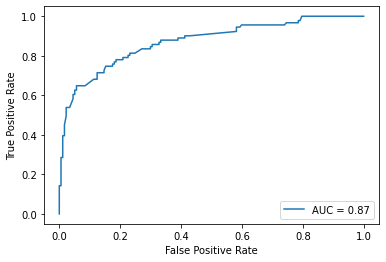

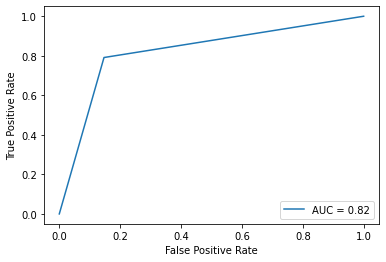

In [34]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(f_test['Survived'], pls_p)
roc_pls = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
fpr1, tpr1, _ = roc_curve(f_test['Survived'],clf_p)
roc_clf = RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=auc(fpr1, tpr1))

roc_pls.plot()
roc_clf.plot()
plt.show()

array([[<AxesSubplot:title={'center':'Survived'}>]], dtype=object)

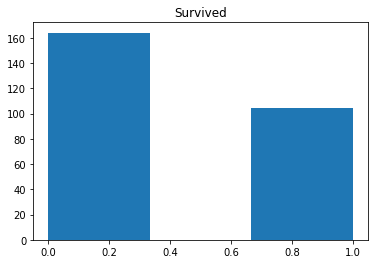

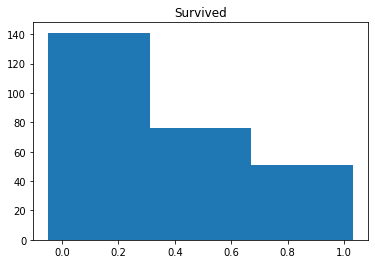

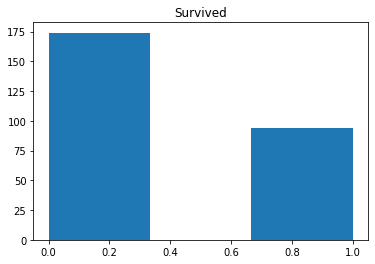

In [54]:
f_test.hist(column='Survived',bins=3,grid=False)
pls_file.hist(column='Survived',bins=3,grid=False)
clf_file.hist(column='Survived',bins=3,grid=False)

Conclusiones:
1. Se puede ver que Desicion trees tiene overfitting debido a que RMSE sube al doble en el testing, por lo que este modelo no es buen predictor para los datos que le entregué (habría que hacer pruning después del training)

2. El cambio de valor de RMSE entre train y test en PLS es de 0.03 lo cual es bueno, pero el R2 sigue siendo malo. Viendo específicamente la curva ROC y el valor AUC (0.87) notamos que el acierto de este modelo es bueno.

3. Ahora para poder detectar qué variables podrían ser sacadas para la mejora de estos modelos podríamos graficar los aciertos con respecto a edad, sexo, clase, cant de familiares pero quedará como trabajo futuro.